<center>
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/FinalModule_Coursera/images/IDSNlogo.png" width="300" alt="cognitiveclass.ai logo"  />
</center>

<h1 align="center"><font size="5">Classification with Python</font></h1>


In this notebook we try to practice all the classification algorithms that we have learned in this course.

We load a dataset using Pandas library, and apply the following algorithms, and find the best one for this specific dataset by accuracy evaluation methods.

Let's first load required libraries:


In [103]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

### About dataset


This dataset is about past loans. The **Loan_train.csv** data set includes details of 346 customers whose loan are already paid off or defaulted. It includes following fields:

| Field          | Description                                                                           |
| -------------- | ------------------------------------------------------------------------------------- |
| Loan_status    | Whether a loan is paid off on in collection                                           |
| Principal      | Basic principal loan amount at the                                                    |
| Terms          | Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effects                                         |
| Due_date       | Since it’s one-time payoff schedule, each loan has one single due date                |
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant                                                               |


Let's download the dataset


In [ ]:
# !wget -O loan_train.csv https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/FinalModule_Coursera/data/loan_train.csv

### Load Data From CSV File


In [2]:
#df = pd.read_csv('loan_train.csv')
df = pd.read_csv('https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/FinalModule_Coursera/data/loan_train.csv')
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


In [3]:
df.shape

(346, 10)

### Convert to date time object


In [4]:
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


# Data visualization and pre-processing


Let’s see how many of each class is in our data set


In [5]:
df['loan_status'].value_counts()

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

260 people have paid off the loan on time while 86 have gone into collection


Let's plot some columns to underestand data better:


In [ ]:
# notice: installing seaborn might takes a few minutes
# !conda install -c anaconda seaborn -y

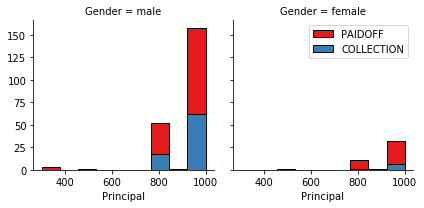

In [6]:
import seaborn as sns

bins = np.linspace(df.Principal.min(), df.Principal.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

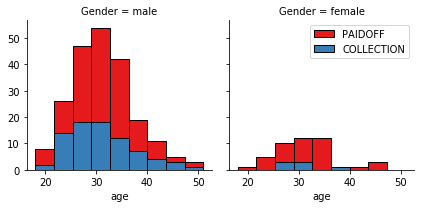

In [7]:
bins = np.linspace(df.age.min(), df.age.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

# Pre-processing:  Feature selection/extraction


### Let's look at the day of the week people get the loan


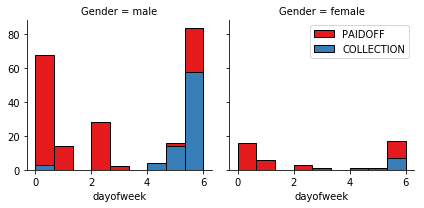

In [8]:
df['dayofweek'] = df['effective_date'].dt.dayofweek
bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()


We see that people who get the loan at the end of the week don't pay it off, so let's use Feature binarization to set a threshold value less than day 4


In [9]:
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,4,1


## Convert Categorical features to numerical values


Let's look at gender:


In [10]:
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
female  PAIDOFF        0.865385
        COLLECTION     0.134615
male    PAIDOFF        0.731293
        COLLECTION     0.268707
Name: loan_status, dtype: float64

86 % of female pay there loans while only 73 % of males pay there loan


Let's convert male to 0 and female to 1:


In [11]:
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,4,1


## One Hot Encoding

#### How about education?


In [12]:
df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bechalor              PAIDOFF        0.750000
                      COLLECTION     0.250000
High School or Below  PAIDOFF        0.741722
                      COLLECTION     0.258278
Master or Above       COLLECTION     0.500000
                      PAIDOFF        0.500000
college               PAIDOFF        0.765101
                      COLLECTION     0.234899
Name: loan_status, dtype: float64

#### Features before One Hot Encoding


In [13]:
df[['Principal','terms','age','Gender','education']].head()

,Principal,terms,age,Gender,education
0,1000,30,45,0,High School or Below
1,1000,30,33,1,Bechalor
2,1000,15,27,0,college
3,1000,30,28,1,college
4,1000,30,29,0,college


#### Use one hot encoding technique to conver categorical varables to binary variables and append them to the feature Data Frame


In [14]:
Feature = df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)
Feature.head()


,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


### Feature Selection


Let's define feature sets, X:


In [15]:
X = Feature
X[0:5]

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


What are our lables?


In [16]:
y = df['loan_status'].values
y[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

## Normalize Data


Data Standardization give data zero mean and unit variance (technically should be done after train test split)


In [17]:
X= preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

array([[ 0.51578458,  0.92071769,  2.33152555, -0.42056004, -1.20577805,
        -0.38170062,  1.13639374, -0.86968108],
       [ 0.51578458,  0.92071769,  0.34170148,  2.37778177, -1.20577805,
         2.61985426, -0.87997669, -0.86968108],
       [ 0.51578458, -0.95911111, -0.65321055, -0.42056004, -1.20577805,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.48739188,  2.37778177,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.3215732 , -0.42056004,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679]])

# Classification


Now, it is your turn, use the training set to build an accurate model. Then use the test set to report the accuracy of the model
You should use the following algorithm:

*   K Nearest Neighbor(KNN)
*   Decision Tree
*   Support Vector Machine
*   Logistic Regression

\__ Notice:\__

*   You can go above and change the pre-processing, feature selection, feature-extraction, and so on, to make a better model.
*   You should use either scikit-learn, Scipy or Numpy libraries for developing the classification algorithms.
*   You should include the code of the algorithm in the following cells.


# K Nearest Neighbor(KNN)

Notice: You should find the best k to build the model with the best accuracy.\
**warning:** You should not use the **loan_test.csv** for finding the best k, however, you can split your train_loan.csv into train and test to find the best **k**.


In [146]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4)
#print ('Train set:', X_train.shape,  y_train.shape)
#print ('Test set:', X_test.shape,  y_test.shape)

Ks = 10
mean_acc = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))

for n in range(1,Ks):
    
    #Train Model and Predict  
    neigh = KNeighborsClassifier(n_neighbors = n).fit(X_train,y_train)
    yhat=neigh.predict(X_test)
    mean_acc[n-1] = metrics.accuracy_score(y_test, yhat)

    
    std_acc[n-1]=np.std(yhat==y_test)/np.sqrt(yhat.shape[0])

mean_acc

array([0.67142857, 0.65714286, 0.71428571, 0.68571429, 0.75714286,
       0.71428571, 0.78571429, 0.75714286, 0.75714286])

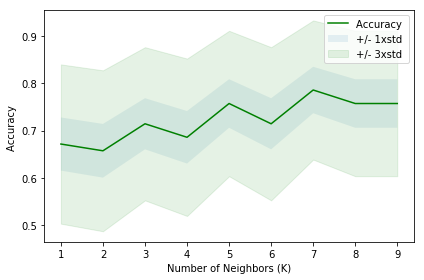

The best accuracy was with 0.7857142857142857 with k= 7


In [147]:
plt.plot(range(1,Ks),mean_acc,'g')
plt.fill_between(range(1,Ks),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.10)
plt.fill_between(range(1,Ks),mean_acc - 3 * std_acc,mean_acc + 3 * std_acc, alpha=0.10,color="green")
plt.legend(('Accuracy ', '+/- 1xstd','+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Neighbors (K)')
plt.tight_layout()
plt.show()
print( "The best accuracy was with", mean_acc.max(), "with k=", mean_acc.argmax()+1) 

In [174]:
k = 7
#Train Model and Predict  

neigh = KNeighborsClassifier(n_neighbors = k).fit(X,y)

'''
neigh = KNeighborsClassifier(n_neighbors = k).fit(X_train,y_train)
yhat_KNN = neigh.predict(X_test)

from sklearn.metrics import f1_score
print('KNN f1_score:')
print(f1_score(y_test, yhat_KNN, average='weighted') )

from sklearn.metrics import jaccard_score
print('KNN jaccard_score:')
print(jaccard_score(y_test, yhat_KNN,pos_label='PAIDOFF'))
'''

"\nneigh = KNeighborsClassifier(n_neighbors = k).fit(X_train,y_train)\nyhat_KNN = neigh.predict(X_test)\n\nfrom sklearn.metrics import f1_score\nprint('KNN f1_score:')\nprint(f1_score(y_test, yhat_KNN, average='weighted') )\n\nfrom sklearn.metrics import jaccard_score\nprint('KNN jaccard_score:')\nprint(jaccard_score(y_test, yhat_KNN,pos_label='PAIDOFF'))\n"

# Decision Tree


In [159]:
from sklearn.tree import DecisionTreeClassifier

myTree = DecisionTreeClassifier(criterion="entropy", max_depth = 6)
# myTree.fit(X_train,y_train)
myTree.fit(X,y)


DecisionTreeClassifier(criterion='entropy', max_depth=6)

In [151]:
# Predict

'''
predTree = myTree.predict(X_test)

from sklearn import metrics
import matplotlib.pyplot as plt
print("DecisionTrees's Accuracy: ", metrics.accuracy_score(y_test, predTree))

from sklearn.metrics import f1_score
print('f1_score:')
print(f1_score(y_test, predTree, average='weighted') )

from sklearn.metrics import jaccard_score
print('jaccard_score:')
print(jaccard_score(y_test, predTree,pos_label='PAIDOFF'))
'''

'\nfrom sklearn import metrics\nimport matplotlib.pyplot as plt\nprint("DecisionTrees\'s Accuracy: ", metrics.accuracy_score(y_test, predTree))\n\nfrom sklearn.metrics import f1_score\nprint(\'f1_score:\')\nprint(f1_score(y_test, predTree, average=\'weighted\') )\n\nfrom sklearn.metrics import jaccard_score\nprint(\'jaccard_score:\')\nprint(jaccard_score(y_test, predTree,pos_label=\'PAIDOFF\'))\n'

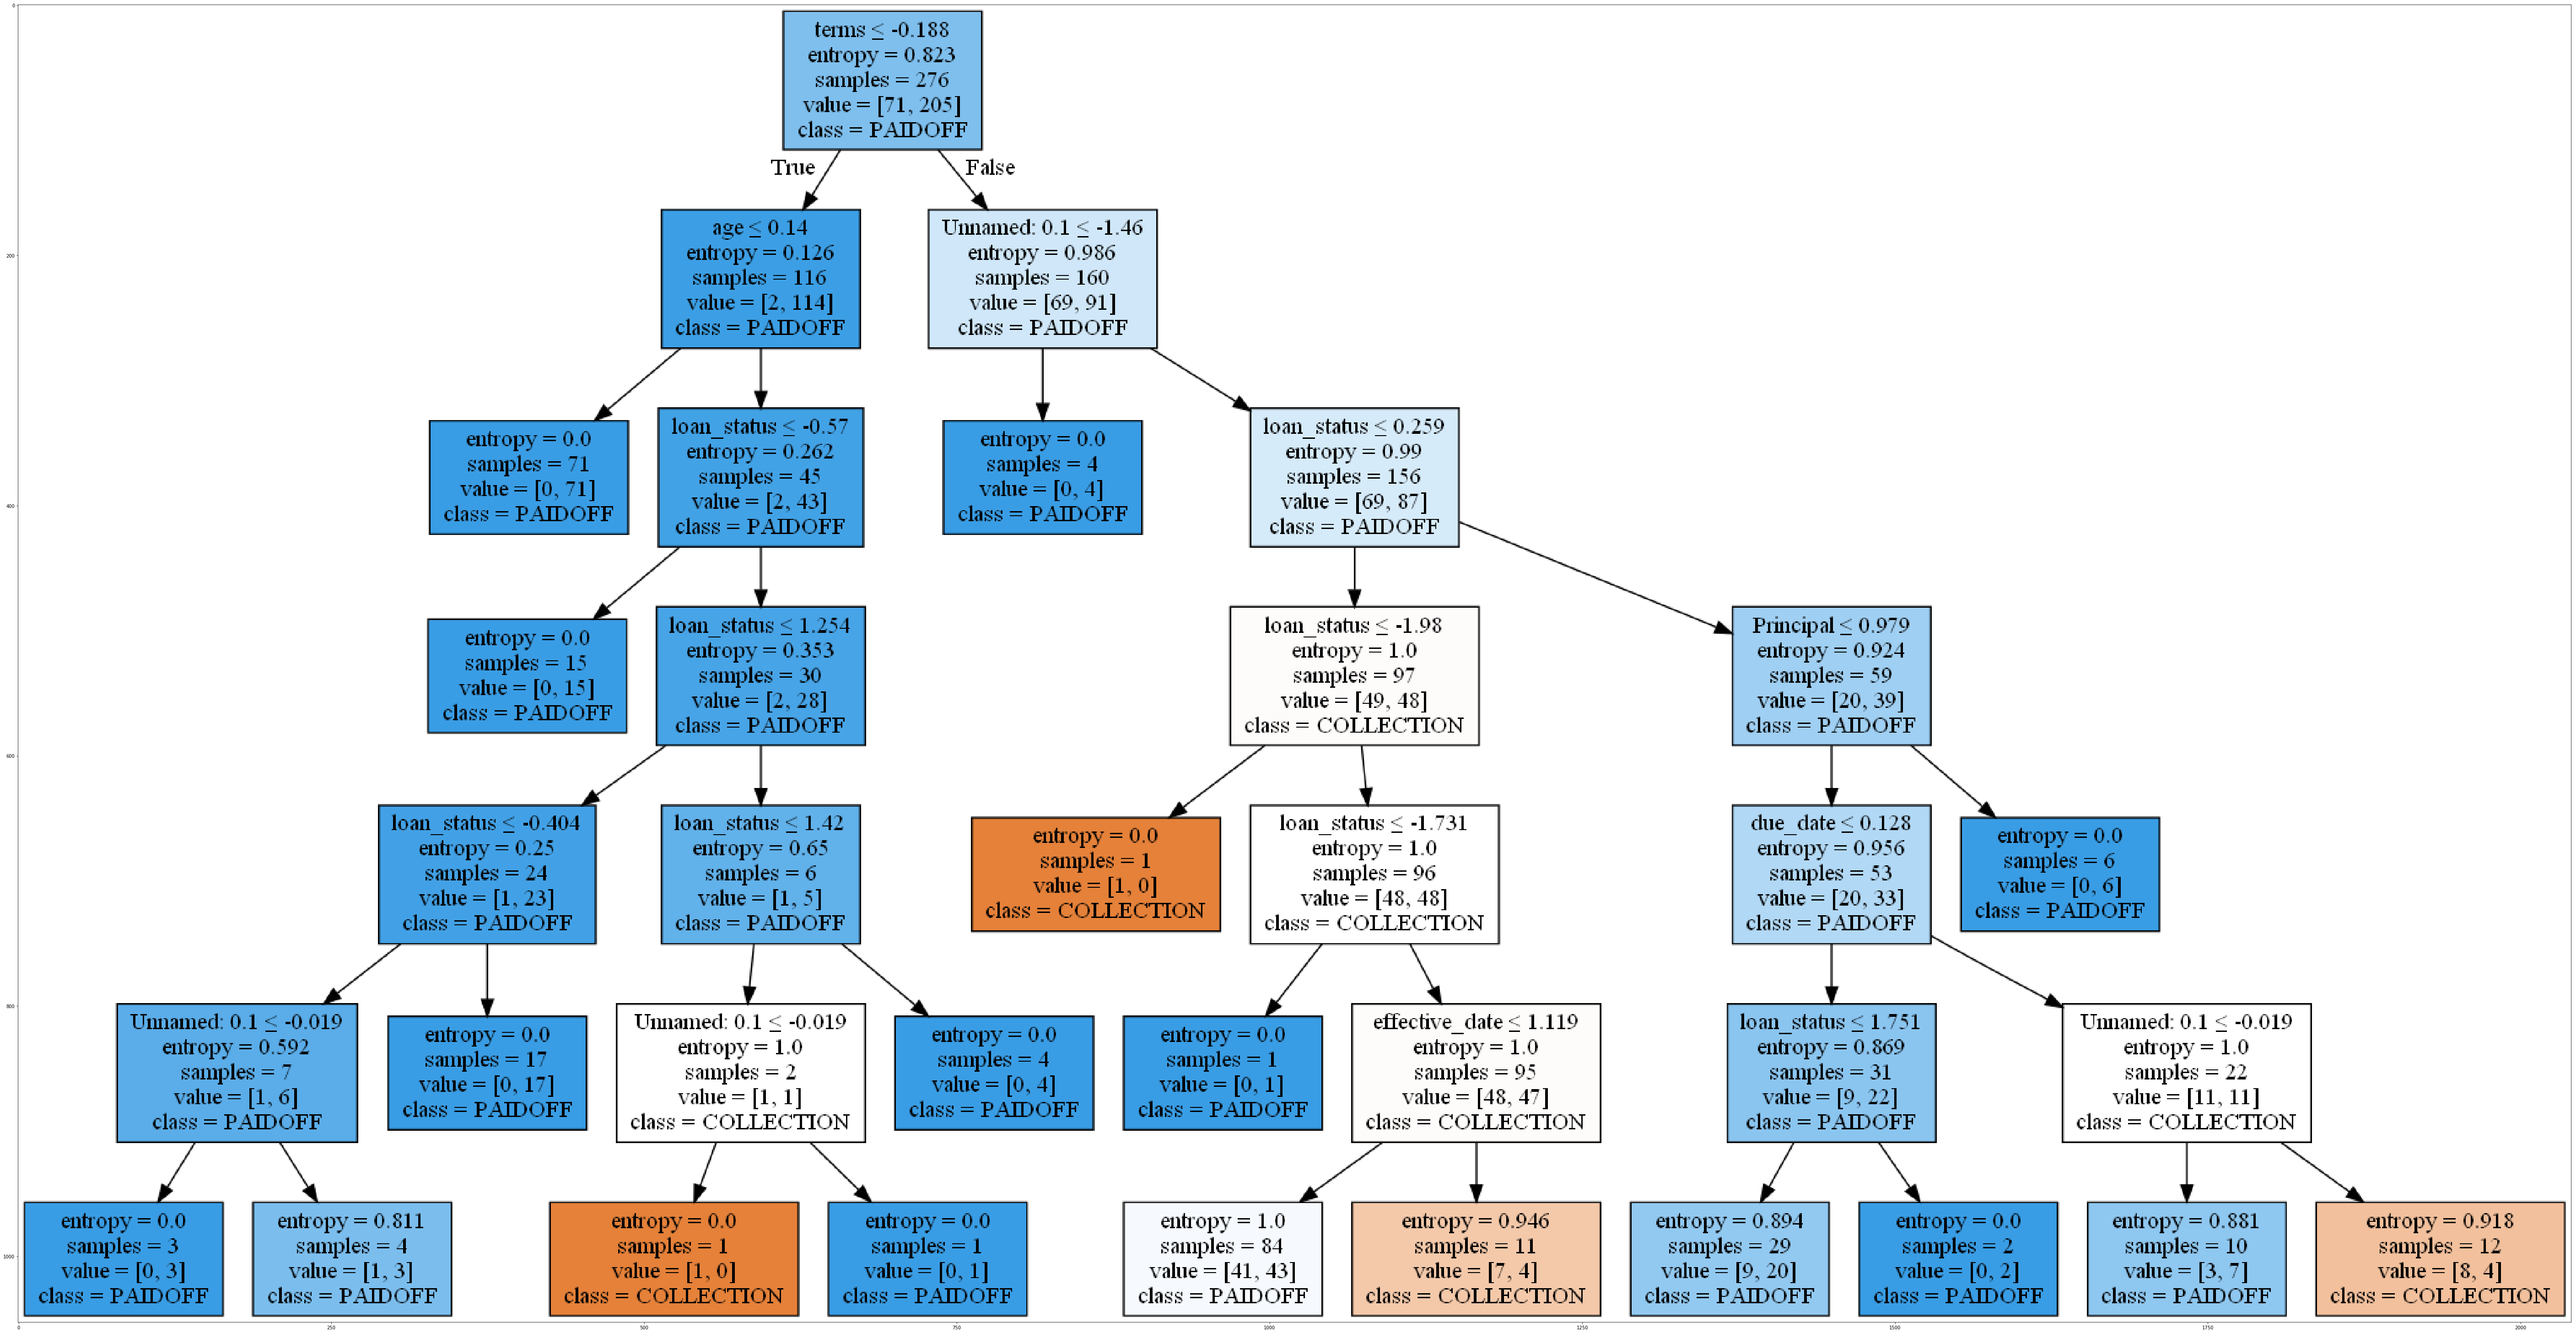

In [152]:
from io import StringIO
import pydotplus
import matplotlib.image as mpimg
from sklearn import tree

dot_data = StringIO()
filename = "diicition_tree.png"
featureNames = df.columns[0:8]
out=tree.export_graphviz(myTree,feature_names=featureNames, out_file=dot_data, class_names= np.unique(y_train), filled=True,  special_characters=True,rotate=False)  
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png(filename)
img = mpimg.imread(filename)
plt.figure(figsize=(100, 200))
plt.imshow(img,interpolation='nearest')

# Support Vector Machine


In [160]:
from sklearn import svm
clf = svm.SVC(kernel='linear')

# Train the model
#clf.fit(X_train, y_train) 
clf.fit(X, y) 

# Predoct
#yhat_SVM = clf.predict(X_test)



SVC(kernel='linear')

In [154]:
'''
from sklearn.metrics import f1_score
print('SVM f1_score:')
print(f1_score(y_test, yhat_SVM, average='weighted') )

from sklearn.metrics import jaccard_score
print('SVM jaccard_score:')
print(jaccard_score(y_test, yhat_SVM,pos_label='PAIDOFF'))
'''

"\nfrom sklearn.metrics import f1_score\nprint('SVM f1_score:')\nprint(f1_score(y_test, yhat_SVM, average='weighted') )\n\nfrom sklearn.metrics import jaccard_score\nprint('SVM jaccard_score:')\nprint(jaccard_score(y_test, yhat_SVM,pos_label='PAIDOFF'))\n"

# Logistic Regression


In [175]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

# Train the model
#LR = LogisticRegression(C=0.01, solver='liblinear').fit(X_train,y_train)
LR = LogisticRegression(C=0.01, solver='liblinear').fit(X,y)
LR

LogisticRegression(C=0.01, solver='liblinear')

In [171]:
# Predict
# yhat_LR = LR.predict(X_test)
# yhat_prob_LR = LR.predict_proba(X_test)
'''
from sklearn.metrics import f1_score
print('f1_score:')
print(f1_score(y_test, yhat_LR, average='weighted') )

from sklearn.metrics import jaccard_score
print('jaccard_score:')
print(jaccard_score(y_test, yhat_LR,pos_label='PAIDOFF'))

from sklearn.metrics import log_loss
print('log_loss:')
print(log_loss(y_test, yhat_prob_LR))
'''

"\nfrom sklearn.metrics import f1_score\nprint('f1_score:')\nprint(f1_score(y_test, yhat_LR, average='weighted') )\n\nfrom sklearn.metrics import jaccard_score\nprint('jaccard_score:')\nprint(jaccard_score(y_test, yhat_LR,pos_label='PAIDOFF'))\n\nfrom sklearn.metrics import log_loss\nprint('log_loss:')\nprint(log_loss(y_test, yhat_prob_LR))\n"

# Model Evaluation using Test set


In [164]:
from sklearn.metrics import jaccard_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss


First, download and load the test set:


In [ ]:
#!wget -O loan_test.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv

### Load Test set for evaluation


In [176]:
#test_df = pd.read_csv('loan_test.csv')
test_df = pd.read_csv('https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv')
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,1,1,PAIDOFF,1000,30,9/8/2016,10/7/2016,50,Bechalor,female
1,5,5,PAIDOFF,300,7,9/9/2016,9/15/2016,35,Master or Above,male
2,21,21,PAIDOFF,1000,30,9/10/2016,10/9/2016,43,High School or Below,female
3,24,24,PAIDOFF,1000,30,9/10/2016,10/9/2016,26,college,male
4,35,35,PAIDOFF,800,15,9/11/2016,9/25/2016,29,Bechalor,male


In [177]:
print(test_df.describe())
test_df['due_date'] = pd.to_datetime(test_df['due_date'])
test_df['effective_date'] = pd.to_datetime(test_df['effective_date'])
test_df['dayofweek'] = test_df['effective_date'].dt.dayofweek
test_df['weekend'] = test_df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
test_df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)
test_df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
test_df= test_df.dropna()
print(test_df)
Feature_ev = test_df[['Principal','terms','age','Gender','weekend']]

Feature_ev = pd.concat([Feature_ev,pd.get_dummies(test_df['education'])], axis=1)
Feature_ev.drop(['Master or Above'], axis = 1,inplace=True)

#print(Feature_ev)

X_ev = Feature_ev
X_ev= preprocessing.StandardScaler().fit(X_ev).transform(X_ev)
y_ev = test_df['loan_status'].values
Feature_ev.head()


       Unnamed: 0  Unnamed: 0.1    Principal      terms        age
count   54.000000     54.000000    54.000000  54.000000  54.000000
mean   182.407407    182.407407   914.814815  21.888889  31.833333
std    116.220759    116.220759   174.190751   8.818220   5.992920
min      1.000000      1.000000   300.000000   7.000000  20.000000
25%     79.500000     79.500000   800.000000  15.000000  28.000000
50%    174.000000    174.000000  1000.000000  30.000000  30.500000
75%    300.250000    300.250000  1000.000000  30.000000  36.000000
max    396.000000    396.000000  1000.000000  30.000000  50.000000
    Unnamed: 0  Unnamed: 0.1 loan_status  Principal  terms effective_date  \
0            1             1     PAIDOFF       1000     30     2016-09-08   
1            5             5     PAIDOFF        300      7     2016-09-09   
2           21            21     PAIDOFF       1000     30     2016-09-10   
3           24            24     PAIDOFF       1000     30     2016-09-10   
4           

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,50,1,0,1,0,0
1,300,7,35,0,1,0,0,0
2,1000,30,43,1,1,0,1,0
3,1000,30,26,0,1,0,0,1
4,800,15,29,0,1,1,0,0


In [178]:
# Use the Load Test set to predict and evaluate the model

# Part 1: KNN
# k = 7
# Use the Load Test to Predict  
yhat_KNN = neigh.predict(X_ev)

# evaluate the model
print("KNN's f1_score: ", f1_score(y_ev, yhat_KNN, average='weighted'))
#print(f1_score(y_ev, yhat_KNN, average='weighted') )

print("KNN's jaccard_score: ", jaccard_score(y_ev, yhat_KNN,pos_label='PAIDOFF'))
#print(jaccard_score(y_ev, yhat_KNN,pos_label='PAIDOFF'))

# Part 2: Decision Tree
# Use the Load Test to Predict 
predTree = myTree.predict(X_ev)

# evaluate the model
print("DecisionTrees's f1_score: ", f1_score(y_ev, predTree, average='weighted'))
#print(f1_score(y_ev, predTree, average='weighted') )

print("DecisionTrees's jaccard_score: ", jaccard_score(y_ev, predTree,pos_label='PAIDOFF'))
#print(jaccard_score(y_ev, predTree,pos_label='PAIDOFF'))

# Part 3: SVM
# Use the Load Test to Predict 
yhat_SVM = clf.predict(X_ev)

# evaluate the model
print("SVM's f1_score: ", f1_score(y_ev, yhat_SVM, average='weighted'))
#print(f1_score(y_ev, yhat_SVM, average='weighted') )

print("SVM's jaccard_score: ", jaccard_score(y_ev, yhat_SVM,pos_label='PAIDOFF'))
#print(jaccard_score(y_ev, yhat_SVM,pos_label='PAIDOFF'))

# Part 3: Logistic Regression
# Use the Load Test to Predict 
yhat_LR = LR.predict(X_ev)
yhat_prob_LR = LR.predict_proba(X_ev)

# evaluate the model
print("Logistic Regression's f1_score: ", f1_score(y_ev, yhat_LR, average='weighted'))
#print(f1_score(y_ev, yhat_LR, average='weighted') )

print("Logistic Regression's jaccard_score: ", jaccard_score(y_ev, yhat_LR,pos_label='PAIDOFF'))
#print(jaccard_score(y_ev, yhat_LR,pos_label='PAIDOFF'))

print("Logistic Regression's log_loss: ", log_loss(y_ev, yhat_prob_LR))
#print(log_loss(y_ev, yhat_prob_LR))

KNN's f1_score:  0.7001989201477693
KNN's jaccard_score:  0.7
DecisionTrees's f1_score:  0.7006734006734008
DecisionTrees's jaccard_score:  0.7254901960784313
SVM's f1_score:  0.6304176516942475
SVM's jaccard_score:  0.7407407407407407
Logistic Regression's f1_score:  0.6304176516942475
Logistic Regression's jaccard_score:  0.7407407407407407
Logistic Regression's log_loss:  0.5566084946309205


# Report

You should be able to report the accuracy of the built model using different evaluation metrics:


| Algorithm          | Jaccard | F1-score | LogLoss |
| ------------------ | ------- | -------- | ------- |
| KNN                | ?       | ?        | NA      |
| Decision Tree      | ?       | ?        | NA      |
| SVM                | ?       | ?        | NA      |
| LogisticRegression | ?       | ?        | ?       |


<h2>Want to learn more?</h2>

IBM SPSS Modeler is a comprehensive analytics platform that has many machine learning algorithms. It has been designed to bring predictive intelligence to decisions made by individuals, by groups, by systems – by your enterprise as a whole. A free trial is available through this course, available here: <a href="http://cocl.us/ML0101EN-SPSSModeler?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML0101ENSkillsNetwork20718538-2021-01-01">SPSS Modeler</a>

Also, you can use Watson Studio to run these notebooks faster with bigger datasets. Watson Studio is IBM's leading cloud solution for data scientists, built by data scientists. With Jupyter notebooks, RStudio, Apache Spark and popular libraries pre-packaged in the cloud, Watson Studio enables data scientists to collaborate on their projects without having to install anything. Join the fast-growing community of Watson Studio users today with a free account at <a href="https://cocl.us/ML0101EN_DSX?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML0101ENSkillsNetwork20718538-2021-01-01">Watson Studio</a>

<h3>Thanks for completing this lesson!</h3>

<h4>Author:  <a href="https://ca.linkedin.com/in/saeedaghabozorgi?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML0101ENSkillsNetwork20718538-2021-01-01?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML0101ENSkillsNetwork20718538-2021-01-01">Saeed Aghabozorgi</a></h4>
<p><a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a>, PhD is a Data Scientist in IBM with a track record of developing enterprise level applications that substantially increases clients’ ability to turn data into actionable knowledge. He is a researcher in data mining field and expert in developing advanced analytic methods like machine learning and statistical modelling on large datasets.</p>

<hr>

## Change Log

| Date (YYYY-MM-DD) | Version | Changed By    | Change Description                                                             |
| ----------------- | ------- | ------------- | ------------------------------------------------------------------------------ |
| 2020-10-27        | 2.1     | Lakshmi Holla | Made changes in import statement due to updates in version of  sklearn library |
| 2020-08-27        | 2.0     | Malika Singla | Added lab to GitLab                                                            |

<hr>

## <h3 align="center"> © IBM Corporation 2020. All rights reserved. <h3/>

<p>
